In [1]:
%matplotlib inline
from os import path
from random import choices
import string
from subprocess import check_call
from time import time

import pandas as pd

from cognite.config import configure_session
from cognite.v06.analytics import models
from cognite.data_transfer_service import DataTransferService, DataSpec, TimeSeriesDataSpec, TimeSeries

# Make sure to set your API key and porject
API_KEY = "<YOUR-API-KEY>"
PROJECT = "<YOUR-PROJECT>"
configure_session(api_key=API_KEY, project=PROJECT)

# We'll prepend all resources we make with this random string
# to avoid collision with others that try this tutorial
random_postfix = "".join(choices(string.ascii_lowercase+string.digits, k=6))

# Introduction

For this tutorial we will train a simple model which will try to find the production rate of some imaginary equipment (named "abc") given the temperature, pressure and rotation speed.

Imagine that we are currently measuring the production rate of this equipment, but continously measuring the rate is costly.
We know that it should be possible infer the rate if we know the temperature, pressure and rotation speed.
So if we could make a model that infers the production rate based on other sensor readings we could cut costs.

Since we're already measuring the production rate we have training data we can use.
We have these time series:

In [2]:
# You can use your own time series ids if you want to try
ts_ids = {
    'abc_temp': <TIMESERIES-ID>,
    'abc_pressure': <TIMESERIES-ID>,
    'abc_rpm': <TIMESERIES-ID>,
    'abc_production_rate': <TIMESERIES-ID>,
    'abc_predicted_production_rate': <TIMESERIES-ID>,
}

The first four time series are populated with sensor values, while the last one (abc_predicted_productio_rate) is a new time series we have created for the purpose of filling it with values from our model.

We'll use data from the last two days as training data.
Let's define a data spec for the training data and plot it:

In [3]:
training_data_spec = DataSpec(time_series_data_specs=[
    TimeSeriesDataSpec(
        aggregates=["avg"],
        granularity="1s",
        start=int(time()*1000)-48*3600*1000,
        end=int(time()*1000),
        time_series=[
            TimeSeries(id=ts_ids["abc_temp"], label="temp"),
            TimeSeries(id=ts_ids["abc_pressure"], label="pressure"),
            TimeSeries(id=ts_ids["abc_rpm"], label="rpm"),
            TimeSeries(id=ts_ids["abc_production_rate"], label="production_rate"),
        ]
    )
])

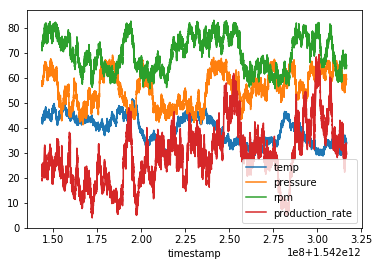

In [4]:
dts = DataTransferService(training_data_spec)
df = dts.get_dataframe()
df.plot(x="timestamp")

We are ready to start making our model!

# 1. Write the code

The first thing we need to do is write the code for our model.
We do this by creating a Python package.
Our package is named `prod_rate` and can be found in a folder with the same name.
Please have a look!
It's just a regular Python package that are pip-installable.
For this tutorial we just train a simple random forrest regression model from scikit-learn.

It's required that your model resides in a class named Model, and that this class is inside a module (i.e. file) named model (model.py). You can read more about this in the docs.
Notice that our requirements (packages that our model needs - in this case scikit-learn) are defined in `setup.py`.

# 2. Create a source package

Before we use our code in Model Hosting we have to upload it.
In Model Hosting, a Python package that defines a model is called a source package.

We first package our code in a tar.gz archive:

In [5]:
# Will create a prod-rate-0.1.tar.gz archive
check_call(["python", "setup.py", "sdist"], cwd="prod_rate")
path.exists("prod_rate/dist/prod-rate-0.1.tar.gz")

True

And then we can upload it and create a new source package

In [6]:
source_package_id = models.create_source_package(
    name=f"prod-rate-v01-{random_postfix}",
    package_name="prod_rate",
    available_operations=["TRAIN", "PREDICT"],
    runtime_version="0.1",
    description="Some description", # Optional
    meta_data={"interesting-metadata": [1, 2, 3]}, # Optional (can be arbitrary JSON)
    file_path="prod_rate/dist/prod-rate-0.1.tar.gz"
)["id"]

# 3. Create a model

A model in Model Hosting is an abstract resource that can consist of any number of model versions.
So before we create and train a specific model version, we need to have a model that will act as a parent container. You can read more about this in the docs.

In [7]:
model_id = models.create_model(
    name=f"tutorial-model-{random_postfix}",
    input_fields=["temp", "pressure", "rpm"],
    output_fields=["production_rate"],
    description="Some description", # Optional
    metadata={"interesting-metadata": [1, 2, 3]}, # Optional (can be arbitrary JSON)
)["id"]

Notice that we define the names of the input and output of our model.
This is necessary if want to use the model for scheduled prediction.
Our model is going to predict `production_rate` given the inputs `temp`, `pressure` and `rpm`.

# 4. Create and train a model version

A model version is a specific instance that is trained and can do prediction.
It uses some source package that you have created earlier and resides under some model.

We will pass in the training data spec as an argument to the training routine.

In [8]:
version_id = models.train_model_version(
    model_id=model_id,
    name=f"tutorial-model-version-{random_postfix}",
    source_package_id=source_package_id,
    description="Some description", # Optional
    metadata={"interesting-metadata": [1, 2, 3]}, # Optional (can be arbitrary JSON)
    args={
        "data_spec": training_data_spec.to_JSON()
    }
)["id"]

Now we just have to wait for our model to be trained and deployed.
We can check the status until its 'READY' (this will take several minutes).

<font color='red'>The rest of the notebook will not work if you don't wait until the model version is ready!</font>

In [9]:
models.get_version(model_id, version_id)["status"]

'READY'

# 5. (Optional) Test predict manually

Now that our model version is ready we can use it to predict.
Let's try to give it a data spec.
We'll try using temperature, pressure and rotation speed from the last three minutes.

In [10]:
predict_response = models.online_predict(
    model_id=model_id,
    version_id=version_id,
    instances=[DataSpec(time_series_data_specs=[
            TimeSeriesDataSpec(
                aggregates=["avg"],
                granularity="1s",
                start=int(time()*1000)-3*60*1000,
                end=int(time()*1000),
                time_series=[
                    TimeSeries(id=ts_ids["abc_temp"], label="temp"),
                    TimeSeries(id=ts_ids["abc_pressure"], label="pressure"),
                    TimeSeries(id=ts_ids["abc_rpm"], label="rpm"),
                ]
            )
        ]).to_JSON()]
)

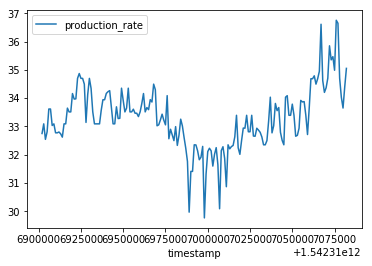

In [11]:
df = pd.DataFrame(predict_response["predictions"][0])
df.plot(x="timestamp")

Now you could evaluate your model or do some other checks, but we will assume that everything looks fine.
We'll go ahead and create a schedule.

# 6. Create schedule

Schedules perform regularly prediction on some specified input using some specified model and writes to specified output.
It's important to note that schedules use models (not model versions directly) to perform predictions.
So you can actually change the implementation of the model by creating a new model version and then setting this as active version.
When you change the active version of a model, it will take immediate effect on all schedules using that model.

Creating a schedule is simply a matter of specifying the model, the input data and the output data.
Specifying the input data is done by using a special data spec that uses `windowSize` and `stride` instead of `start` and `end`.
`windowSize` is the timespan of datapoints that each individual prediction will receive,
while `stride` is how often to do prediction.
Note that if `stride < windowSize` you will receive the same datapoints multiple times because windows overlap.
This can be nice if your model needs some look-back for each prediction.

We'll set up our schedule to take in `abc_temp`, `abc_pressure`, `abc_rpm` and write predictions to `abc_predicted_production_rate`.

In [12]:
schedule_id = models.create_schedule(
    model_id=model_id,
    name=f"tutorial-schedule-{random_postfix}",
    input_data_spec={
        "windowSize": "1m",
        "stride": "1m",
        "aggregate": "avg",  # Will apply for all time series unless overidden
        "granularity": "1s", # Will apply for all time series unless overidden
        "missingDataStrategy": "ffill", # Optional
        "timeSeries": [
            {"label": "temp", "id": ts_ids["abc_temp"]},
            {"label": "pressure", "id": ts_ids["abc_pressure"]},
            {"label": "rpm", "id": ts_ids["abc_rpm"]},
        ],
    },
    output_data_spec={
        "timeSeries": [
            {"label": "production_rate", "id": ts_ids["abc_predicted_production_rate"]},
        ],
    },
    args={}, # Optional - Will be passed to all predictions
    description="Some description", # Optional
    meta_data={"interesting-metadata": [1, 2, 3]}, # Optional (can be arbitrary JSON)
)["id"]

Now we just have to wait.
We will get the first datapoints in approximately one minute.

# 7. Check the output

When we have waited a while we can take a look at the output.
Let's compare the measured and the predicted production rate the last 20 minutes:

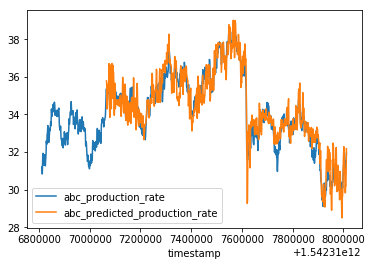

In [13]:
dts = DataTransferService(DataSpec(time_series_data_specs=[
    TimeSeriesDataSpec(
        aggregates=["avg"],
        granularity="1s",
        start=int(time()*1000)-22*60*1000,
        end=int(time()*1000)-2*60*1000,
        time_series=[
            TimeSeries(id=ts_ids["abc_production_rate"]),
            TimeSeries(id=ts_ids["abc_predicted_production_rate"]),
        ]
    )
]))
df = dts.get_dataframe()
df.plot(x="timestamp")

Not bad!
But it can probably be better.
You can try to improve it, upload the new source package, train a new model version and then change the active version of this model.